In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import random

import so_ml_tools as soml

import tensorflow as tf
import pandas as pd
import numpy as np

import tensorflow_hub as hub

from keras import Model
from keras import layers
from keras import losses
from keras import optimizers

2023-09-12 10:50:29.322013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best result is available here: https://aclanthology.org/E17-2110.pdf

## Get Data

Since we'll be replicating the paper above (PubMed 200K RTC), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [4]:
!ls pubmed-rct

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
# Check wat kind of files are in the PubMed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
dev.txt  test.txt  train.txt


In [6]:
# Start our experiments using the 20K data set with numbers replaced with @ sign.
data_dir = './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [7]:
# Check all the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to... visualize visualize visualize...

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [8]:
# Create a function to read the lines of a document
def get_lines(filename: str) -> list[str]:
    """
    Reads filename (a text filename) and returns all of the lines of text as a list.
    :param filename:
    :return:
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [9]:
# Let's read in the training lines
train_lines = get_lines(f"{data_dir}/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

[{line_number: 0, target: 'BACKGROUND', text: 'Emotional eating is associated with overeating and the development of obesity .', total_lines: 11}]

In [11]:
def preprocess_text_with_line_numbers(filepath: str) -> list[dict]:
    """
    takes in filenanem reads it contents and sorts through each line, extracting things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.

    :param filepath: the file path
    :return: list of dictionaries
    """
    lines = get_lines(filepath)

    abstract_lines = ""
    abstract_samples = []

    for line in lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                target, text = abstract_line.split('\t')

                line_data = {
                    "line_number": abstract_line_number,
                    "target": target,
                    "text": text.lower(),
                    "total_lines": len(abstract_lines_split)
                }
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [12]:
%%time
train_samples = preprocess_text_with_line_numbers(f"{data_dir}/train.txt")
val_samples = preprocess_text_with_line_numbers(f"{data_dir}/dev.txt")
test_samples = preprocess_text_with_line_numbers(f"{data_dir}/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 142 ms, sys: 22 ms, total: 164 ms
Wall time: 163 ms


(180040, 30212, 30135)

In [13]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of dictionaries, how about we turn it into a dataframe to further visualize it.

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,6,RESULTS,there was a clinically relevant reduction in t...,12
7,7,RESULTS,the mean difference between treatment arms ( @...,12
8,8,RESULTS,"further , there was a clinically relevant redu...",12
9,9,RESULTS,these differences remained significant at @ we...,12


In [15]:
# Distributions of labels in the training set
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

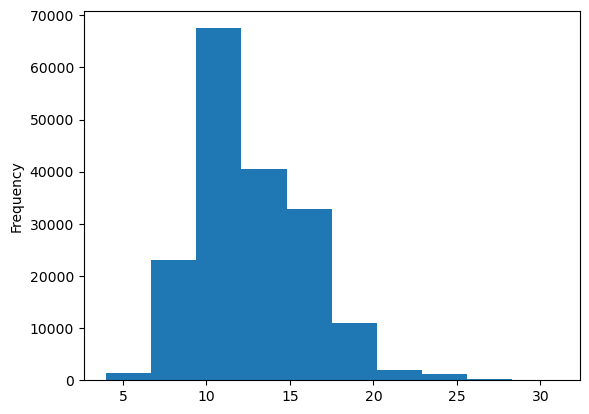

In [16]:
# Check the length of different lines
train_df.total_lines.plot.hist()

In [17]:
### Get list of sentences
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

<Axes: ylabel='Frequency'>

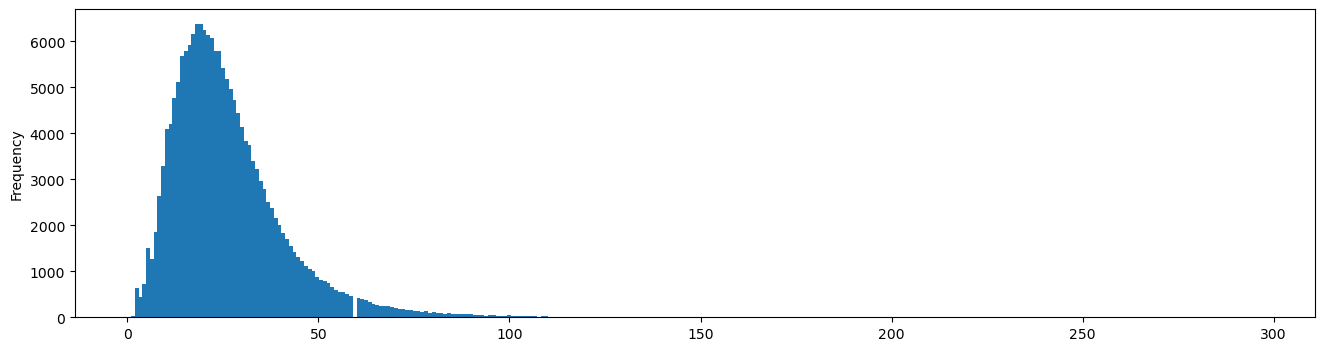

In [19]:
train_df['text'].map(lambda l: len(l.split())).plot.hist(figsize=(16,4), bins=300)

## Making numeric labels (ML Models require numeric labels)

In [20]:
# One hot encode labels
encoder, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot = \
    soml.pd.dataframe.one_hot_encode_column(
        train_df['target'],
        val_df['target'],
        test_df['target']
    )

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
train_df['target'].to_numpy().ndim, train_df['target'].to_numpy().reshape(-1, 1).ndim

(1, 2)

### Label encode labels

In [22]:
# Extract labels ("target" column) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from Label Encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [24]:
test_df['target'].to_numpy()

array(['BACKGROUND', 'RESULTS', 'RESULTS', ..., 'RESULTS', 'RESULTS',
       'CONCLUSIONS'], dtype=object)

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best. And as always, we're going to start with a baseline (TF-IDF) Multinomial Naive Bayes classifier.

#Model 0: Getting a baseline

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded) # We need to use the encoded labels and not the one-hot labels, it expects a sparse result

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our base pipeline on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [27]:
# Make predictions using our baseline model
model_0_prob = model_0.predict(X=val_sentences)

In [28]:
model_0_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels_encoded, y_pred=model_0_prob)
model_0_results

,accuracy,f1-score,precision,recall
0,72.183238,0.698925,0.718647,0.721832


## Preparing our data (the text) for deep sequence model

Before we start building deep models we got to create vectorization and embedding layers

In [32]:
# How long is each sentence on average
average_sentence_length = soml.nlp.text.calculate_average_character_length_for_all_sentences(train_sentences)
average_sentence_length

149

In [33]:
# How long of a sentence length covers 95% of examples?
output_sequence_length = soml.nlp.text.calculate_q_precentile_word_lengths(lines=train_sentences, q=95)
output_sequence_length

55

### Create Text Vectorizer layer

We want to make a layer which maps our text from words to numbers.

In [34]:
# How many words are there in our vocabulary? (taken from table 2 in the paper: https://arxiv.org/pdf/1710.06071.pdf )
max_tokens = soml.nlp.text.count_unique_words(train_sentences)

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_sequence_length,
    pad_to_max_tokens=True
)

max_tokens

64839

In [35]:
# Adapt TextVectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
len(target_sentence.split()), target_sentence

(43,
 'compared with group b , group a had less bp , hr changes at skin incision and needed less intraoperative sufentanil ( ( @ @ ) g/kg vs ( @ @ ) g/kg ) ( p < @ ) to maintain anesthesia .')

In [37]:
text_vectorizer(target_sentence)

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([  34,    7,   13,  186,   13,    8,   55,  211,  664,  273,  146,
         15,  538, 1619,    3,  440,  211,  842, 3960, 1518,   44, 1518,
         14,    6, 1858,  435,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [38]:
# How many words in our vocabulary
len(text_vectorizer.get_vocabulary())

64839

In [39]:
# What are the most common words in our vocabulary
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [40]:
# What are the least common words in our vocabulary
text_vectorizer.get_vocabulary()[-5:]

['aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener']

In [41]:
# Get the config of our TextVectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 64839,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64839}

## Create custom text embedding

In [42]:
# Create token embedding layer
token_embedding = layers.Embedding(
    input_dim=max_tokens, # Length of vocabulary
    output_dim=128, # Note: Different embedding sizing results in drastically different number of parameters to train.
    mask_zero=True, # Use masking to handle variable sequence lengths (save space)
    input_length=output_sequence_length,
    name="token_embedding"
)
token_embedding

In [43]:
print(f"Original text: {target_sentence} \
      \n\rEmbedded version:")

# Embedd the random sentence (turn it into dense vectors of fixed size)
sample_embed = token_embedding(text_vectorizer([target_sentence]))
sample_embed, sample_embed.shape

Original text: compared with group b , group a had less bp , hr changes at skin incision and needed less intraoperative sufentanil ( ( @ @ ) g/kg vs ( @ @ ) g/kg ) ( p < @ ) to maintain anesthesia .       
Embedded version:


(<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[ 0.00448866,  0.04562665, -0.0254853 , ..., -0.01492434,
           0.02729626, -0.0195537 ],
         [-0.01132616,  0.04939594, -0.01989475, ..., -0.01478436,
           0.00827154, -0.00130333],
         [ 0.0273279 ,  0.00630086,  0.03953466, ..., -0.01281454,
          -0.03127293, -0.02704721],
         ...,
         [ 0.029731  , -0.04123101, -0.02407628, ...,  0.00653752,
          -0.02786814, -0.03389247],
         [ 0.029731  , -0.04123101, -0.02407628, ...,  0.00653752,
          -0.02786814, -0.03389247],
         [ 0.029731  , -0.04123101, -0.02407628, ...,  0.00653752,
          -0.02786814, -0.03389247]]], dtype=float32)>,
 TensorShape([1, 55, 128]))

## Creating Datasets (making sure our data loads as fast as possible)

https://www.tensorflow.org/guide/data_performance
https://www.tensorflow.org/guide/data

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources.

In [44]:
# Turn our data into TensorFlow datasets.
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
train_labels_one_hot.shape, train_labels_one_hot[:1]

((180040, 5), array([[0., 0., 0., 1., 0.]]))

In [46]:
# Take the TensorSliceDataset's and turn them into prefetched datasets.
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D model to process sequences

In [47]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x) # condense the output from feature vector from conv layer
outputs = layers.Dense(units=num_classes, activation="softmax")(x)

model_1 = Model(inputs, outputs, name="model_0_conv1d")


In [48]:
model_1.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_0_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299392   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [49]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # Only use 10% of the dataset.
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)) # Only use 10% of the dataset.
                              )

Epoch 1/3
562/562 [==============================] - 15s 25ms/step - loss: 0.9161 - accuracy: 0.6375 - val_loss: 0.6839 - val_accuracy: 0.7424
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.6519 - accuracy: 0.7602 - val_loss: 0.6267 - val_accuracy: 0.7739
Epoch 3/3
562/562 [==============================] - 2s 3ms/step - loss: 0.6138 - accuracy: 0.7766 - val_loss: 0.5946 - val_accuracy: 0.7826


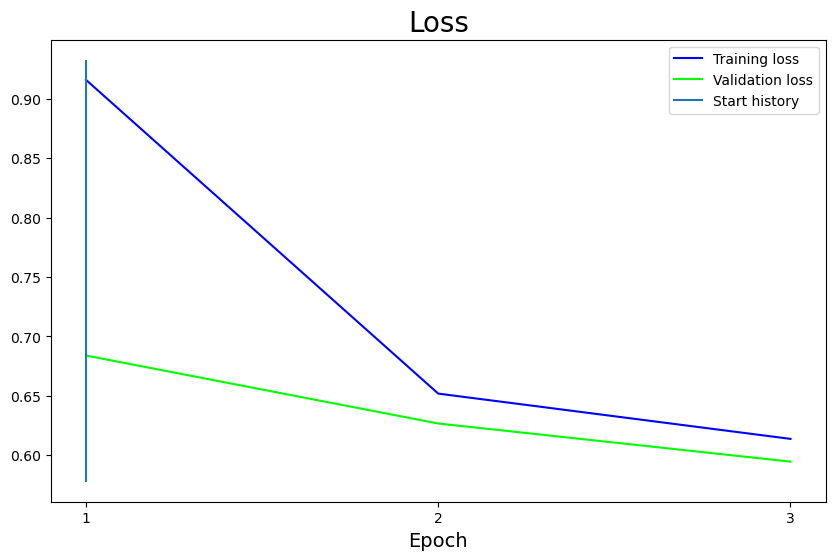

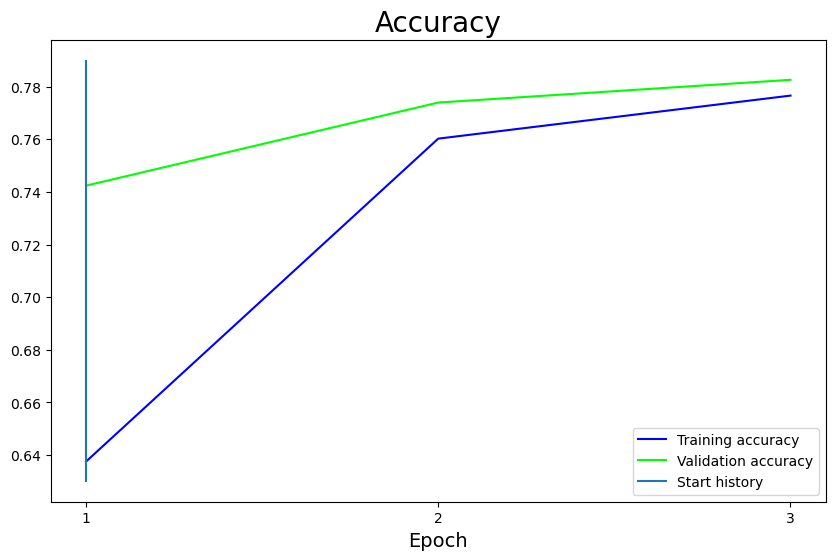

In [50]:
soml.tf.model.plot.plot_history(history=model_1_history)

In [51]:
# Evaluate dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 1s 1ms/step - loss: 0.5952 - accuracy: 0.7873


[0.595187246799469, 0.7873030304908752]

In [52]:
# Make some predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 1s 826us/step


(array([[4.2612863e-01, 1.6178393e-01, 6.4749941e-02, 3.2281518e-01,
         2.4522277e-02],
        [4.3435973e-01, 2.8576812e-01, 1.4411253e-02, 2.5604510e-01,
         9.4158296e-03],
        [1.3328964e-01, 4.8795440e-03, 1.1719017e-03, 8.6061960e-01,
         3.9257626e-05],
        ...,
        [5.4723268e-06, 6.5363484e-04, 5.8031298e-04, 5.3636581e-06,
         9.9875522e-01],
        [4.6824943e-02, 4.3147427e-01, 1.0712166e-01, 6.7456655e-02,
         3.4712249e-01],
        [1.6307740e-01, 7.2753781e-01, 4.5689374e-02, 3.0400366e-02,
         3.3294979e-02]], dtype=float32),
 (30212, 5))

In [53]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [54]:
model_1_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_results

,accuracy,f1-score,precision,recall
0,78.730306,0.785085,0.784854,0.787303


In [55]:
# TODO: Create function to show difference including percentage.
model_0_results

,accuracy,f1-score,precision,recall
0,72.183238,0.698925,0.718647,0.721832


## Feature Extaction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hun, more specifically the uneiversal sentence encoder.

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [56]:
# Download pretrained TensorFlow HUB USE
# hub.load(handle="https://tfhub.dev/google/universal-sentence-encoder/4")

In [57]:
# Create Keras Layer using the USE pretrained layer from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], # Since the input is defined as english text of variable length the layer in itself will make sure it fits
                                        dtype=tf.string,
                                        trainable=False, # we are doing feature extraction so we do not want to train this layer
                                        name='USE'
                                      )

In [58]:
# Test out the pretrained embedding on some random sentence
tf_hub_embedding_layer([target_sentence])[0][:30]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([-0.06819727, -0.07339792,  0.04758636, -0.02725039,  0.0404012 ,
       -0.01460574,  0.06084268, -0.04064356, -0.01923765,  0.02986355,
        0.07659619,  0.00415782,  0.02660927, -0.00607714,  0.03460333,
       -0.00108062, -0.07149789, -0.02316085, -0.00767382,  0.07192165,
        0.03221511,  0.03769464, -0.05810696,  0.02422468,  0.04893114,
        0.01081914,  0.01136447,  0.06098796, -0.00601783, -0.03246813],
      dtype=float32)>

# Model 2: Building and fitting future extraction model using pretrained embeddings TensorFlow Hub

In [59]:
 # Create model using the Sequential API

input = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = layers.Dense(units=128, activation='relu')(x) # Using 64 layers did not achieve as nice results.
output = layers.Dense(units=num_classes, activation='softmax')(x)

model_2 = Model(input, output)

model_2.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [60]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 0.9153 - accuracy: 0.6484 - val_loss: 0.7967 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.7689 - accuracy: 0.7028 - val_loss: 0.7553 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.7527 - accuracy: 0.7118 - val_loss: 0.7395 - val_accuracy: 0.7158


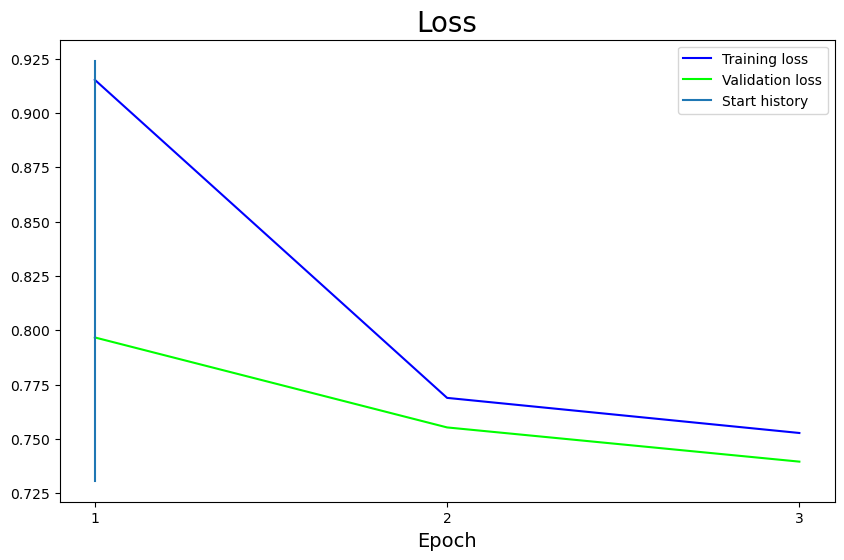

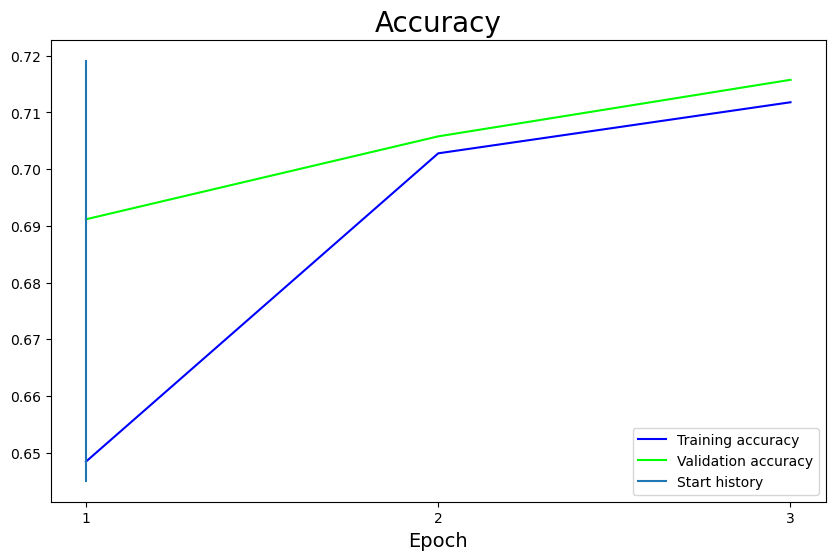

In [61]:
soml.tf.model.plot.plot_history(history=model_2_history)

In [62]:
# Evaluate the feature extraction model
model_2.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7413 - accuracy: 0.7142


[0.7413079738616943, 0.7141532897949219]

In [63]:
# Let's make some predictions with the feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)

945/945 [==============================] - 4s 4ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [66]:
# Calculate results from TensorFlow Hub pretrained embedding
model_2_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels_encoded, y_prob=model_2_pred_probs)
model_2_results

,accuracy,f1-score,precision,recall
0,71.415332,0.711483,0.714284,0.714153


In [65]:
model_0_results

,accuracy,f1-score,precision,recall
0,72.183238,0.698925,0.718647,0.721832


# Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings. Previously we've token0level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [67]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [68]:
# make function to split sentences into characters
def split_chars(text: str):
    return " ".join(list(text))

# Text splitting non-character level sequence into characters
split_chars(target_sentence)

'c o m p a r e d   w i t h   g r o u p   b   ,   g r o u p   a   h a d   l e s s   b p   ,   h r   c h a n g e s   a t   s k i n   i n c i s i o n   a n d   n e e d e d   l e s s   i n t r a o p e r a t i v e   s u f e n t a n i l   (   (   @   @   )   g / k g   v s   (   @   @   )   g / k g   )   (   p   <   @   )   t o   m a i n t a i n   a n e s t h e s i a   .'

In [69]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [71]:
# Find what character length covers 95% of sequences
output_sequence_char_length = soml.nlp.text.calculate_q_precentile_character_lengths_for_all_sentence(train_sentences)
num_char_tokens, _ = soml.nlp.text.count_unique_chars(train_sentences)

output_sequence_char_length, num_char_tokens, str(_)

(290,
 27,
 "{'s', 'f', 'y', 'x', 'h', 'q', 'b', 'j', 'z', 'i', 'd', 'a', 'u', 'g', 'n', 'p', 'l', 'm', ' ', 'r', 'c', 'o', 'e', 'k', 'v', 'w', 't'}")

In [72]:
# Create char-level token vectorizer instance
char_vectorizer = layers.TextVectorization(max_tokens=num_char_tokens + 1, # Add one for OOV, space is already included
                                           output_sequence_length=output_sequence_char_length,
                                           standardize="lower_and_strip_punctuation",
                                           name="char_vectorizer")

In [73]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [74]:
character_vocabulary = char_vectorizer.get_vocabulary()
print(f"Number of different characters in vocabulary: {len(character_vocabulary)}")
print(f"Characters: {character_vocabulary}")

Number of different characters in vocabulary: 28
Characters: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [75]:
# Test out character vectorization
target_chars = random.choice(train_chars)
print(f"Value of target_chars:\n {target_chars}")
print(f"\nLength of target_chars : {len(target_chars.split())}")

vectorized_chars = char_vectorizer([target_chars])
print(f"\nVectorized of target_chars : {vectorized_chars}")
print(f"\nLength of vectorized target_chars : {len(vectorized_chars[0])}")

Value of target_chars:
 i n c i d e n c e   o f   n e c   s t a g e   @   w e r e   s i m i l a r   i n   b o t h   t h e   g r o u p s   ,   @   v s .   @   %   (   p   =   @   )   .

Length of target_chars : 59

Vectorized of target_chars : [[ 4  6 11  4 10  2  6 11  2  7 17  6  2 11  9  3  5 18  2 20  2  8  2  9
   4 15  4 12  5  8  4  6 22  7  3 13  3 13  2 18  8  7 16 14  9 21  9 14
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

## Creating a character level embedding

In [76]:
# Create character embedding layer
char_embedding = layers.Embedding(
    input_dim=len(char_vectorizer.get_vocabulary()), # Length of vocabulary
    output_dim=25, # Note: Character embedding (how many features per character)
    mask_zero=True, # Use masking to handle variable sequence lengths (save space)
    name="char_embedding"
)

In [77]:
# Test our character embedding layer
print(f"Charified text (length: {len(target_chars)}):\n {target_chars}")
target_chars_embedded = char_embedding(char_vectorizer([target_chars]))
print(f"Embedded charified text (after vectorization):\n {target_chars_embedded}")
print(f"Embedded charified text shape: {target_chars_embedded.shape}")

Charified text (length: 159):
 i n c i d e n c e   o f   n e c   s t a g e   @   w e r e   s i m i l a r   i n   b o t h   t h e   g r o u p s   ,   @   v s .   @   %   (   p   =   @   )   .
Embedded charified text (after vectorization):
 [[[ 0.01345447 -0.03803278  0.0291728  ... -0.00504152  0.02794251
    0.02694507]
  [ 0.02606821 -0.00404725  0.04617255 ... -0.02352136  0.01754915
    0.03697583]
  [ 0.03171993  0.04079564  0.00368299 ... -0.04640285 -0.01079969
   -0.00794854]
  ...
  [ 0.04139723 -0.04428637  0.02689842 ...  0.03840273  0.04468029
   -0.03549675]
  [ 0.04139723 -0.04428637  0.02689842 ...  0.03840273  0.04468029
   -0.03549675]
  [ 0.04139723 -0.04428637  0.02689842 ...  0.03840273  0.04468029
   -0.03549675]]]
Embedded charified text shape: (1, 290, 25)


## Build the model

In [78]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPooling1D()(x) # condense the output from feature vector from conv layer
outputs = layers.Dense(units=num_classes, activation="softmax")(x)

model_3 = Model(inputs, outputs, name="model_4_conv1d")

In [79]:
model_3.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])
model_3.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)              

In [80]:
# Create datasets with batching and prefetching
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_chars_dataset = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = val_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_chars_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
# Fit the model on characters only
model_3_history = model_3.fit(train_chars_dataset,
                              steps_per_epoch=int(0.1 * len(train_chars_dataset)),
                              validation_data=val_chars_dataset,
                              validation_steps=int(0.1 * len(val_chars_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 2s 3ms/step - loss: 1.2743 - accuracy: 0.4748 - val_loss: 1.0790 - val_accuracy: 0.5711
Epoch 2/3
562/562 [==============================] - 1s 2ms/step - loss: 1.0329 - accuracy: 0.5904 - val_loss: 0.9683 - val_accuracy: 0.6164
Epoch 3/3
562/562 [==============================] - 1s 2ms/step - loss: 0.9415 - accuracy: 0.6303 - val_loss: 0.8737 - val_accuracy: 0.6692


In [82]:
# Make predictions with character model 3
model_3_pred_props = model_3.predict(val_chars_dataset)

945/945 [==============================] - 1s 1ms/step


In [83]:
model_3_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels_encoded, y_prob=model_3_pred_props)
model_3_results

,accuracy,f1-score,precision,recall
0,65.268767,0.642653,0.6518,0.652688


# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embeddings)

1. Create a token level embedding model (similar to model_1)
2. Create a character level model (similar to model_3 with a slight modification)
3. Combine 1 and 2 with a concatenate layer (layers.Concatenate)
4. Build a series of output layers on top of 3 similar to figure 1 section 4.2 of the paper https://aclanthology.org/E17-2110.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [84]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token-input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(units=128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Setup charaxcter inputs/models
character_inputs = layers.Input(shape=[], dtype=tf.string, name="character-input")
character_vectors = char_vectorizer(character_inputs)
character_embeddings = char_embedding(character_vectors)
character_bi_lstm = layers.Bidirectional(layers.LSTM(units=24))(character_embeddings) # bi-lstm as shown in Figure 1 (https://aclanthology.org/E17-2110.pdf)
characer_model = tf.keras.Model(inputs=character_inputs, outputs=character_bi_lstm)

# 3. Concatentate token and character inputs (create hybrid token embedding)
token_character_concat = layers.Concatenate(name="token_character_hybrid")([token_model.output, characer_model.output])

# 4. Create output layers adding in dropout (this is discussed in section 4.2 of paper (https://aclanthology.org/E17-2110.pdf)
combined_dropout = layers.Dropout(rate=.5)(token_character_concat)
combined_dense = layers.Dense(units=128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(rate=.5)(combined_dense)
output = layers.Dense(units=5, activation="softmax")(final_dropout)

# 5. Construct model with character and token inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs,characer_model.inputs], outputs=output, name="model_4_token_and_character_embeddings")

In [85]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_character_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 character-input (InputLaye  [(None,)]                    0         []                            
 r)                                                                                               
                                                                                                  
 token-input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['character-input[0][0]']     
 rization)                                                                                        
                                                             

In [86]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [87]:
# Compile token / character model
model_4.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

## Combining token and character data into a tf.Dataset

In [88]:
# Important the order must be the same as the order specified in the inputs of model_4 (token then character)
train_token_character_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_token_character_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_token_character_dataset = tf.data.Dataset.zip((train_token_character_data, train_token_character_label)) # Combine data and label
train_token_character_dataset = train_token_character_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # Setup batching / prefetching

val_token_character_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_token_character_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make labels
val_token_character_dataset = tf.data.Dataset.zip((val_token_character_data, val_token_character_label)) # Combine data and label
val_token_character_dataset = val_token_character_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # Setup batching / prefetching

In [89]:
# Check our training char and token embedding dataset
train_token_character_dataset, val_token_character_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting a model on token and character sequences

In [90]:
model_4_history = model_4.fit(train_token_character_dataset,
                              steps_per_epoch=int(.1 * len(train_token_character_dataset)),
                              validation_data=val_token_character_dataset,
                              validation_steps=int(.1 * len(val_token_character_dataset)),
                              epochs=3)

Epoch 1/3


2023-09-12 13:30:22.348551: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'


562/562 [==============================] - 16s 20ms/step - loss: 0.9831 - accuracy: 0.6112 - val_loss: 0.7759 - val_accuracy: 0.7058
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7965 - accuracy: 0.6946 - val_loss: 0.7088 - val_accuracy: 0.7330
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7716 - accuracy: 0.7065 - val_loss: 0.6929 - val_accuracy: 0.7340


In [91]:
# Evaluate on the whole validation set
model_4.evaluate(val_token_character_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.6964 - accuracy: 0.7350


[0.6964179277420044, 0.7350059747695923]

In [92]:
# Make predictions using the token-character model hybrid
model_4_pred_props = model_4.predict(val_token_character_dataset)
model_4_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels_encoded, y_prob=model_4_pred_props)
model_4_results

945/945 [==============================] - 8s 8ms/step


,accuracy,f1-score,precision,recall
0,73.500596,0.732929,0.735424,0.735006


## Model 5: Transfer learning with pretrained token embedding + character embedding + positional embeddings

In [93]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


> **Note**: Any engineered features used to train the model need to be available during test-time. In our case, line-numbers and total lines are available.

### Positional embeddings

In [96]:
# How many different line nubmers are there.
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [ ]:
# Check the distribution of "line_number" column
train_df['line_number'].plot.hist()

In [97]:
# Use TensorFlow to create one-hot encoded tensors of our line number column. Reason to use one-hot encoding is to not give the impression that line number 2 is more important then line number 1 using for example MinMaxScaler.
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [100]:
train_df['total_lines'].value_counts()

total_lines
12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: count, dtype: int64